# Hardware Testing Processes - data acquisition on Rigol Instruments :

see Setup and Debugging help at end of file.

- The instrumentation course covers the base topics of industrial instrumentation: sensors and how they work, A-D and D-A converters, instruments useful for taking measures, communication buses used in instrumentation, calibration, …

- The instrumentation labs make use of the python and VISA protocol. It allows the students to learn a software widely used in the industry in order to design automated and autonomous instrumentation systems.

### Class def

In [1]:
import pyvisa
import time

class RigolInstrument:
    def __init__(self, resource_name, verbose=1):
        self.verbose = verbose
        self.inst = pyvisa.ResourceManager("@py").open_resource(resource_name)
        self.inst.timeout = 5000
        self.inst.encoding = 'utf-8'
        self.idn = self.get_idn()
        self.instrument_type = self.classify_instrument()

    def get_idn(self):
        try:
            self.inst.write('*IDN?')
            time.sleep(0.1)
            return self.inst.read().strip()
        except pyvisa.errors.VisaIOError:
            if self.verbose >= 2:
                print(f"  ✗ IDN query failed: {e}")
            return "Unknown"

    def getter_idn(self):
        return self.idn

    def classify_instrument(self):
        idn_upper = self.idn.upper()
        if "RIGOL" in idn_upper and "DG" in idn_upper:
            return "generator"
        elif "RIGOL" in idn_upper and ("DS" in idn_upper or "MSO" in idn_upper):
            return "oscilloscope"
        else:
            return "unknown"

    def write(self, command):
        self.inst.write(command)

    def query(self, command):
        return self.inst.query(command)
        
    def read(self):
        return self.inst.read()

    def close(self):
        self.inst.close()
        time.sleep(2)
    
    def __str__(self):
        return f"{self.instrument_type.capitalize()} - IDN: {self.idn}"

    def toggle(channel, state, self):
        # ------ CH1 ----------
        if channel == "CH1":
            if state == "ON":
                self.write("OUTP1 ON")
            else:
                self.write("OUTP1 OFF")
        # ------ CH2 ----------
        elif channel == "CH2":
            if state == "ON":
                self.write('OUTP:CH2 ON ')
            else:
                self.write('OUTP:CH2 OFF ')
        return

    def generate_waveform(self, channel, waveform_type, frequency, amplitude, offset=0, phase=0, duty_cycle=50):
        """Note that writing to CH1 is different from writing to CH2...."""
        args = f"{frequency}, {amplitude}, {offset} "
        
        if channel == "CH1":
            # print(channel)
            self.write('VOLT:UNIT VPP')
            time.sleep(0.05)
            self.write(f'APPL:{waveform_type} {args}')   # e.g. APPL:RAMP 1000, 2.5, 0.5
            time.sleep(0.05)
            self.write(f'PHAS {phase} ')
            time.sleep(0.05)
            self.write("OUTP1 ON")
            # self.toggle("CH1", "ON", self)

        else:
            # for CH2 use the CH-specific notation...
            self.write(f'VOLT:UNIT:{channel} VPP')
            time.sleep(0.05)
            self.write(f'APPL:{waveform_type}:{channel} {args}')  # e.g. APPL:SQUare:CH2 1000, 2.5, 0.5
            time.sleep(0.05)
            self.write(f'PHAS:{channel} {phase} ')
            time.sleep(0.05)
            self.write('OUTP:CH2 ON ')
            # self.toggle(f"CH2", "ON", self)

# =========================================

def detect_rigol_instruments(verbose=1):
    """
    Retourne un tuple (generator, oscilloscope) si présents, sinon None.
    
    Verbose : 0 = silent, 1 = normal, 2 = debug
    
    """
    rm = pyvisa.ResourceManager("@py")
    devices = [d for d in rm.list_resources() if "USB" in d]

    # prints
    if verbose >=2:
        print(f"Devices : {devices}")

    generator = None
    oscilloscope = None
    if verbose >=1: print("Detecting...")

    for dev in devices:
        rigol = RigolInstrument(dev)
        if rigol.instrument_type == "generator":
            generator = rigol
            if verbose >=2: print(f"Detected Generator: {generator}")
            if verbose == 1: print(f"Generator Detected.")

        elif rigol.instrument_type == "oscilloscope":
            oscilloscope = rigol
            if verbose >=2: print(f"Detected Oscilloscope: {oscilloscope}")
            if verbose == 1: print(f"Oscilloscope Detected.")
    return generator, oscilloscope


generator, oscilloscope = detect_rigol_instruments(verbose=2)

if generator:
    generator.close()
else:
    print("No generator detected.")

if oscilloscope:
    oscilloscope.close()
else:
    print("No oscilloscope detected.")



Devices : ['USB0::6833::1416::DG1D114803890\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00::0::INSTR', 'USB0::6833::1230::DS1ZC212301095::0::INSTR']
Detecting...
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022 ,DG1D114803890,,00.02.00.06.00.02.05
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301095,00.04.04.SP4


## Session 1:

### Rigol DG1022 :


In [2]:


# 1 - Connect to DG1022Z (and DS1054Z)
generator, oscilloscope = detect_rigol_instruments()




# 2 - Toggle CH1, CH2
def manual_toggle_channels_test():
    t =2
    generator.write("OUTP1 ON")
    time.sleep(t)
    generator.write("OUTP1 OFF")
    time.sleep(t)
    generator.write('OUTP:CH2 ON ')
    time.sleep(t)
    generator.write('OUTP:CH2 OFF')
    time.sleep(t)





# ! DOESNT WORK ?
def class_toggle_channels_test():
    t = 2
    generator.toggle("CH1", "ON")
    time.sleep(t)
    generator.toggle("CH1", "OFF")
    time.sleep(t)
    generator.toggle("CH2", "ON")
    time.sleep(t)
    generator.toggle("CH2", "OFF")
    time.sleep(t)



# 3 - Sine Function
def waveforms_test(wave):
    for w in wave:
        generator.generate_waveform(channel="CH1", waveform_type=w, frequency=1000, amplitude=5)
        print(f'CH1 is a : {w}')
        time.sleep(2)

    for w in wave:
        generator.generate_waveform(channel="CH2", waveform_type=w, frequency=1000, amplitude=5)
        print(f'CH2 is a : {w}')
        time.sleep(2)




# ===== TESTS ======


# manual_toggle_channels_test()

# class_toggle_channels_test()


wave = {
    "sin":"SINusoid",
    "square" : "SQUare",
    "ramp" : "RAMP",
    "pulse" : "PULSe",
    "noise" : "NOISe",
    "dc" : "DC"
}
# waveforms_test(wave)

# generator.generate_waveform(channel="CH1", waveform_type="sin", frequency=1000, amplitude=5)
# time.sleep(2)
# generator.generate_waveform(channel="CH2", waveform_type="ramp", frequency=1000, amplitude=5)




# Close
generator.close()
oscilloscope.close()




Detecting...
Oscilloscope Detected.
Generator Detected.


### 4 - Exponential Wave Flattening by capacitor:

In [3]:
# 4.On a breadboard, use a capacitor to flatten an exponential wave generated by the generator
#  (find the right information in the manual). Watch your signal on the oscilloscope.


### 6 - Record and Save in CSV:

In [4]:
# . Record all the information of exercise 5 in a CSV file with a timeline and show it with a
#  graph

### 7 - (Challenge) Generate song into Speaker:

In [5]:
# 7. Challenge : Use a song as an arbitrary waveform and make it generated by the generator
#  into the speaker. (ask the speaker to the professors)

---
## Session 2- the Oscilloscope-DS1104 :

### DS1104 - Z Plus

In [ ]:
# 1 - Connect to DG1022Z (and DS1054Z)
generator, oscilloscope = detect_rigol_instruments(verbose=1)


generator.close()
oscilloscope.close()

Detecting...
Oscilloscope Detected.
Generator Detected.


### 2 - Oscilloscope:

Create a program that can interface the oscilloscope and plot VRMS as a function of 
- (a) Use numpy
- (b) use Use MatplotLib (Some people may encounter an error of "non interactive plot", in this case, you can install pyQT5 (or higher)  with the line pip install pyqt5)



In [7]:
import numpy as np
import matplotlib.pyplot as plt

def measure_vrms(ds, channel='CH1'):
    """Get a single VRMS measurement from the scope."""
    ds.write(f':MEAS:SOUR {channel}')
    time.sleep(0.05)
    result = ds.query(':MEAS:ITEM? VRMS')
    return float(result.strip())

def plot_vrms(times, values, title="VRMS vs Time", show_average=True):
    """Plot VRMS data with optional average line."""
    plt.figure(figsize=(10, 5))
    plt.plot(times, values, 'o-', label='VRMS samples')
    
    if show_average:
        avg = np.nanmean(values)
        plt.axhline(avg, color='r', linestyle='--', label=f'Average: {avg:.6f} V')
    
    plt.xlabel('Time (s)')
    plt.ylabel('VRMS (V)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [8]:


def test_vrms_measurement():
    # Connect Oscilloscope and Function Generator
    generator, oscilloscope = detect_rigol_instruments()
    if oscilloscope and generator:
        # Generate DC with Ampl=5V on CH1
            # Waves : (sin, square, ramp, pulse, noise, dc)
        generator.generate_waveform(channel="CH1", waveform_type=wave["sin"], frequency=1000, amplitude=5)
        
        # time.sleep(5)

        # Measure VRMS
        print(measure_vrms(oscilloscope, 'CH1'))    #! Should print 1.78 V (=Vrms of 5Vpp sine wave)
        time.sleep(1)

        # Plot
        # plot_vrms()
        
        # Close
        generator.close()
        oscilloscope.close()



# test_vrms_measurement()   # ! Make sure Oscilloscope channels are Probe x1 and not x10...




In [9]:
# 2. To measure an accurate value of the VRMS take several values of it (10 then 100), plot all
#  the value and the average of its. Don’t forget to leave some time to the data to be stored
#  (500ms per scan).

def collect_samples(ds, n_samples, wait_ms=500, channel='CHAN1'):
    """Collect n samples with specified wait time. Returns (times, values)."""
    times = []
    values = []
    start = time.time()
    print_val = []

    
    for i in range(n_samples):
        try:
            val = measure_vrms(ds, channel)
            values.append(val)
            times.append(time.time() - start)
            print_val.append(f"{val:.3f} V")
            time.sleep(wait_ms / 1000.0)
        except Exception as e:
            print(f"Sample {i+1} failed: {e}")
            values.append(np.nan)
            times.append(time.time() - start)
    print(print_val)
    return np.array(times), np.array(values)


In [10]:
# Connect Oscilloscope and Function Generator
generator, oscilloscope = detect_rigol_instruments()

def test_vrms_measurement_multiple_samples():
    if oscilloscope and generator:
        # Generate DC with Ampl=5V on CH1
        generator.generate_waveform(channel="CH1", waveform_type=wave["square"], frequency=1000, amplitude=5)  # Waves : (sin, square, ramp, pulse, noise, dc)
        time.sleep(1)

        # Collect samples and plot
        t10, v10 = collect_samples(oscilloscope, n_samples=10, wait_ms=500, channel='CHAN1')
        plot_vrms(t10, v10, title="VRMS - 10 samples (500ms)", show_average=True)

        # Close
        generator.close()
        oscilloscope.close()


# test_vrms_measurement_multiple_samples()



Detecting...
Oscilloscope Detected.
Generator Detected.


In [11]:
# 3. Let’s start reducing the value of waiting. Compute the minimum waiting time and
#  with it the sampling rate of VRMS on the oscilloscope.

def find_min_delay(ds, test_delays=[500, 250, 100, 50, 25, 10, 5, 1], n_test=10, channel='CHAN1'):
    """Find minimum reliable delay between measurements. Returns (min_delay_ms, max_rate_hz)."""
    for delay_ms in test_delays:
        print(f"\nTesting {delay_ms}ms delay...")
        t_start = time.time()
        success = 0
        
        for i in range(n_test):
            try:
                measure_vrms(ds, channel)
                success += 1
                time.sleep(delay_ms / 1000.0)
            except Exception as e:
                print(f"  Failed at sample {i+1}: {e}")
                break
        
        elapsed = time.time() - t_start
        
        if success == n_test:
            rate = success / elapsed
            print(f"  ✓ SUCCESS: {success}/{n_test} in {elapsed:.3f}s → {rate:.2f} Hz")
            return delay_ms, rate
        else:
            print(f"  ✗ FAILED: {success}/{n_test} samples")
    
    return None, None


In [12]:


def test_min_delay():
    # Connect Oscilloscope and Function Generator
    generator, oscilloscope = detect_rigol_instruments()

    if oscilloscope and generator:
        min_delay, max_rate = find_min_delay(oscilloscope, channel='CHAN1')
        if min_delay:
            print(f"\nMinimum delay: {min_delay}ms")
            print(f"Maximum sampling rate: {max_rate:.2f} Hz")


        # Close
        generator.close()
        oscilloscope.close()

# test_min_delay()



### 3 - Full Wave Measurement

Goal :
- captures and plots a raw waveform (the actual voltage samples over time) from the oscilloscope screen.

In [13]:
#  Try this code that allows you to read what you see on the oscilloscope. 
# How does it perform?

import time
import numpy as n
import matplotlib.pyplot as mp

t = 2

def read_oscilloscope_waveform():
    generator, osc = detect_rigol_instruments()
    time.sleep(3)
    print(f"*IDN : {osc.getter_idn()}")

    # reading procedure initialisation
    osc.write(':WAVeform:FORMat ASCII') #easy to read information but slower
    time.sleep(t)
    osc.write(':WAVeform:Mode NORMAL') #see programming book
    time.sleep(t)
    L1 = osc.query(':WAVeform:PREamble?') #to know everything
    time.sleep(t)
    print(L1)
    osc.write(':WAVform:SOURce Channel1')
    time.sleep(t)
    D1 = osc.query(':WAVEFORM:DATA?')
    time.sleep(t)
    D2 = D1.split(',')
    Lgth = n.size(D2)
    mp.plot(n.linspace(0,1,Lgth-1),D2[1:Lgth])




# What code could help you get a better plot of your data? 
    # Print D1 or D2, this might help you to find the answer. 
    # Hint : the ascii format is not convenient to plot your data , 
    # try to cast it into an usable one.


def test_teacher_functions():
    print("==============================")
    generator, osc = detect_rigol_instruments()
    time.sleep(3)
    print(f"*IDN : {osc.getter_idn()}")

    time.sleep(2)

    # Ensure channel 1 is ON
    osc.write(':CHAN1:DISP ON')
    time.sleep(0.5)

    # Configure waveform capture
    osc.write(':WAV:SOUR CHAN1')
    osc.write(':WAV:MODE NORM')
    osc.write(':WAV:FORM ASC')   # send numbers instead of binary bytes

    # Get preamble (metadata)
    preamble = osc.query(':WAV:PRE?')
    print("Preamble:", preamble)
    # Parse preamble into named variables
    preamble_values = preamble.split(',')

    format_type = int(preamble_values[0])      # 0=BYTE, 1=WORD, 2=ASCII
    acq_type = int(preamble_values[1])         # 0=NORMAL, 1=AVERAGE, 2=PEAK, 3=HIGH_RES
    points = int(preamble_values[2])           # Number of waveform points
    count = int(preamble_values[3])            # Always 1 for NORMAL mode
    x_increment = float(preamble_values[4])    # Time between points (seconds)
    x_origin = float(preamble_values[5])       # Time of first point (seconds)
    x_reference = int(preamble_values[6])      # Always 0
    y_increment = float(preamble_values[7])    # Voltage per ADC level
    y_origin = float(preamble_values[8])       # Voltage at center screen
    y_reference = int(preamble_values[9])      # ADC value at center (usually 127)

    print(f"""
    Parsed Preamble:
    Format: {format_type} (2=ASCII)
    Points: {points}
    Count : {count}
    Time/sample: {x_increment*1e6:.3f} µs
    Voltage/level: {y_increment*1000:.3f} mV
    XY-origin: {x_origin:.1f}/{y_origin:.1f} V
    """)
    



    # Fetch waveform data
    raw_data = osc.query(':WAV:DATA?')
    print("First 200 chars of raw data:", raw_data[:200])

    # Parse ASCII data
    values = raw_data.split(',')
    print(f"Number of points: {len(values)}")

    # Convert to float array (skip first element if it's a header like '#')
    if values[0].startswith('#'):
        values = values[1:]

    y_data = np.array([float(v) for v in values if v.strip()])

    # Plot
    x_data = np.linspace(0, 1, len(y_data))
    plt.figure(figsize=(10, 5))
    plt.plot(x_data, y_data)
    plt.xlabel('Normalized Time')
    plt.ylabel('Voltage (V)')
    plt.title('Oscilloscope Waveform')
    plt.grid(True)
    plt.show()

    osc.close()

#  ==========

#! Note: only for testing (not working), read next functions for better impl
    # read_oscilloscope_waveform()
    # test_teacher_functions()


### 4 - Phase Measurement

Based on two identical sinusoidal signals but having a difference in phase, perform a delay and
phase measurement. 

Does it correspond to the signal generated by the rigol generator? To go
further, you can generate the signal in Python with the DG1022.

In [5]:

# Phase Measurement Exercise
import numpy as np
import matplotlib.pyplot as plt
import time

def capture_waveform(osc, channel='CHAN1', verbose=True):
    """Capture waveform using proper IEEE block format (WORKING VERSION)"""
    
    # Configure oscilloscope
    osc.write(f':WAV:SOUR {channel}')
    time.sleep(0.2)
    osc.write(':WAV:MODE NORM')
    time.sleep(0.2)
    osc.write(':WAV:FORM BYTE')
    time.sleep(0.2)
    
    # Get preamble (metadata about the waveform)
    preamble = osc.query(':WAV:PRE?')
    preamble_values = preamble.split(',')
    
    points = int(preamble_values[2])           # How many samples
    x_increment = float(preamble_values[4])    # Time between samples
    x_origin = float(preamble_values[5])       # Starting time
    y_increment = float(preamble_values[7])    # Voltage per unit
    y_origin = float(preamble_values[8])       # Zero voltage
    y_reference = int(preamble_values[9])      # Center byte value (usually 127)
    
    if verbose:
        print(f"  Capturing {points} samples from {channel}...")
    
    # CRITICAL: Write the query command FIRST
    osc.write(':WAV:DATA?')
    time.sleep(0.5)  # Let scope prepare data
    
    # Set timeout for binary data
    original_timeout = osc.inst.timeout
    osc.inst.timeout = 30000  # 30 second timeout
    
    try:
        # Read the IEEE block header first
        # Format: #9000001200 (11 bytes) where 9=num_digits, 000001200=data_length
        header = osc.inst.read_raw(11)
        
        if header[0:1] != b'#':
            raise ValueError(f"Expected IEEE header starting with '#', got {header}")
        
        # Parse header to get actual data length
        num_digits = int(header[1:2])
        data_length_str = header[2:2+num_digits].decode('utf-8')
        data_length = int(data_length_str)
        
        if verbose: print(f"  Header: {header}, data_length={data_length}")
        
        # Now read the actual sample bytes
        raw_bytes = osc.inst.read_raw(data_length)
        
        # FIXED: Convert bytes to numpy array and use actual mean as reference
        # This removes the DC offset issue from y_reference/y_origin mismatch
        byte_array = np.frombuffer(raw_bytes, dtype=np.uint8)
        y_data = (byte_array - np.mean(byte_array)) * y_increment
        
        # Create time axis
        time_axis = np.arange(len(y_data)) * x_increment + x_origin
        
        preamble_dict = {
            'points': points,
            'x_increment': x_increment,
            'x_origin': x_origin,
            'y_increment': y_increment,
            'y_origin': y_origin,
            'y_reference': y_reference
        }
        
        if verbose: print(f"  ✓ Captured {len(y_data)} points successfully")
        return time_axis, y_data, preamble_dict
        
    finally:
        osc.inst.timeout = original_timeout




def calculate_phase_difference(time1, signal1, time2, signal2, frequency):
    """
    Calculate phase difference between two sinusoidal signals.
    Returns (phase_deg, time_delay_us).
    """
    # Ensure same time base
    if not np.array_equal(time1, time2):
        print("Warning: Time bases don't match exactly")
    
    # Find zero crossings (rising edge)
    def find_first_rising_zero(t, sig):
        # Find where signal crosses zero going positive
        mean_val = np.mean(sig)
        centered = sig - mean_val
        
        for i in range(len(centered) - 1):
            if centered[i] <= 0 and centered[i+1] > 0:
                # Linear interpolation for exact crossing
                t_cross = t[i] - centered[i] * (t[i+1] - t[i]) / (centered[i+1] - centered[i])
                return t_cross
        return None
    
    # Find first zero crossing for each signal
    t_cross1 = find_first_rising_zero(time1, signal1)
    t_cross2 = find_first_rising_zero(time2, signal2)
    
    if t_cross1 is None or t_cross2 is None:
        print("Error: Could not find zero crossings")
        return None, None
    
    # Calculate time delay
    time_delay = abs(t_cross2 - t_cross1)  # seconds
    
    # Calculate phase difference
    period = 1.0 / frequency  # seconds
    phase_rad = (time_delay / period) * 2 * np.pi
    phase_deg = np.degrees(phase_rad) % 360
    
    return phase_deg, time_delay * 1e6  # return delay in microseconds


def plot_dual_waveforms(time1, sig1, time2, sig2, phase_deg, delay_us, freq):
    """Plot both waveforms with phase info."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot both signals overlaid
    ax1.plot(time1 * 1e6, sig1, label='CH1', alpha=0.7)
    ax1.plot(time2 * 1e6, sig2, label='CH2', alpha=0.7)
    ax1.set_xlabel('Time (µs)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_title(f'Phase Difference: {phase_deg:.2f}° | Time Delay: {delay_us:.3f} µs | Frequency: {freq/1000:.1f} kHz')
    ax1.grid(True)
    ax1.legend()
    
    # Plot zoomed section (first few periods)
    periods_to_show = 3
    t_end = periods_to_show / freq
    mask1 = time1 <= t_end
    mask2 = time2 <= t_end
    
    ax2.plot(time1[mask1] * 1e6, sig1[mask1], 'o-', label='CH1', markersize=3)
    ax2.plot(time2[mask2] * 1e6, sig2[mask2], 'o-', label='CH2', markersize=3)
    ax2.set_xlabel('Time (µs)')
    ax2.set_ylabel('Voltage (V)')
    ax2.set_title(f'Zoomed: First {periods_to_show} periods')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()



Devices : ['USB0::6833::1230::DS1ZC212301101::0::INSTR', 'USB0::1024::2500::DG1D205204683\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00::0::INSTR']
Detecting...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301101,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022 ,DG1D205204683,03.03.00.13.00.03.01

=== Generating signals ===
Frequency: 10.0 kHz
Amplitude: 2.0 Vpp
CH1 phase: 0°
CH2 phase: 45°

=== Capturing waveforms ===
  Capturing 1200 samples from CHAN1...
  Header: b'#9000001200', data_length=1200
  ✓ Captured 1200 points successfully
CH1: 1200 points captured
  Capturing 1200 samples from CHAN2...
  Header: b'#9000001200', data_length=1200
  ✓ Captured 1200 points successfully
CH2: 1200 points captured

=== Calculating phase difference ===
Note : The DG1022 channels are completely independent — setting CH2 phase to 45° doesn't mean "45° relative to CH1", it means "45° relative to CH2's own arbitrary start time". The 

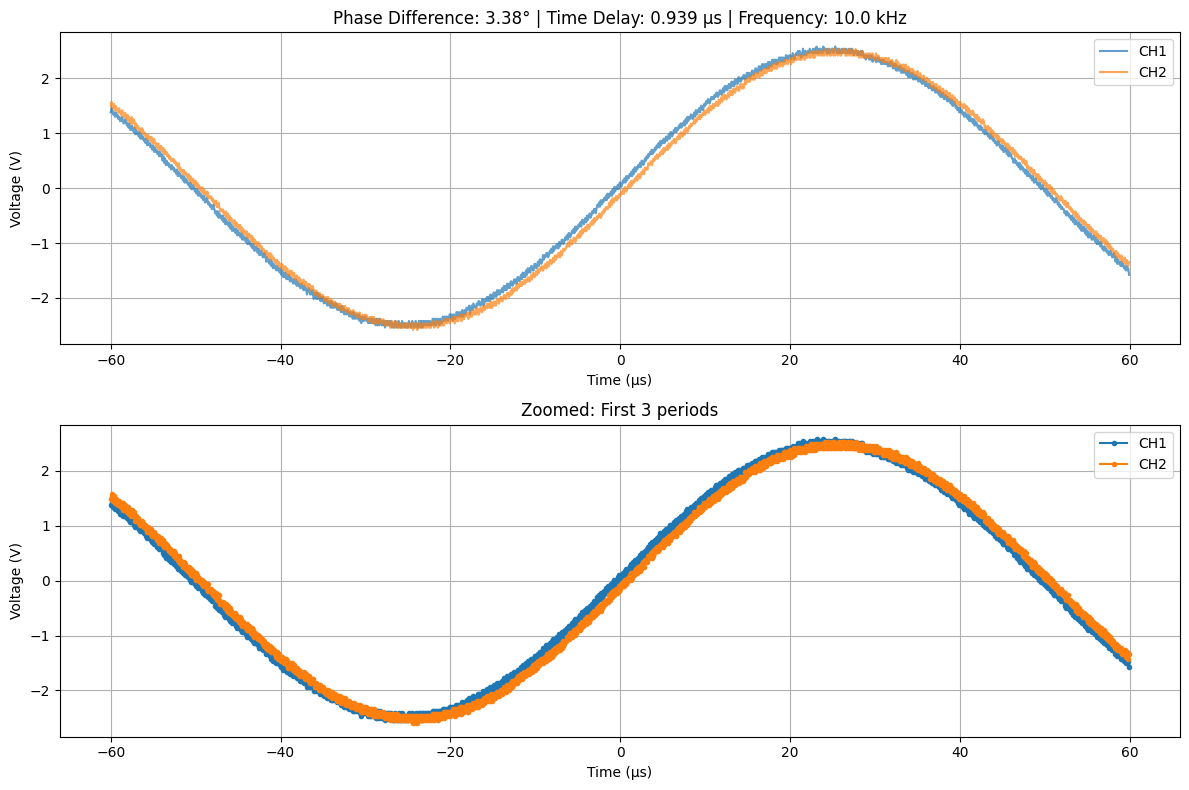

In [52]:
# ==================== MAIN EXECUTION ====================

def dual_phase_measurement_test(generateFlag=True, rigol_verbose=1):
    # Connect instruments
    time.sleep(2)
    generator, osc = detect_rigol_instruments(verbose=rigol_verbose)
    time.sleep(5)

    if not generator or not osc:
        print("Error: Both generator and oscilloscope must be connected.")
        return


    # Define test parameters
    test_frequency = 10000  # 10 kHz
    test_amplitude = 2.0    # 2V peak-to-peak
    phase_ch2 = 45          #! Set CH2 to 45° phase shift


    print(f"\n=== Generating signals ===")
    print(f"Frequency: {test_frequency/1000:.1f} kHz")
    print(f"Amplitude: {test_amplitude} Vpp")
    print(f"CH1 phase: 0°")
    print(f"CH2 phase: {phase_ch2}°")


    if generator and generateFlag == True:
    # Generate identical sinusoids with phase difference
        generator.generate_waveform(
            channel="CH1",
            waveform_type=wave["sin"],
            frequency=test_frequency,
            amplitude=test_amplitude,
            phase=0
        )

        time.sleep(5)

        generator.generate_waveform(
        channel="CH2",
        waveform_type=wave["sin"],
        frequency=test_frequency,
        amplitude=test_amplitude,
        phase=phase_ch2
    )


    time.sleep(2)  # Let signals stabilize

    # Capture waveforms from both channels
    print("\n=== Capturing waveforms ===")
    osc.write(':CHAN1:DISP ON')
    osc.write(':CHAN2:DISP ON')
    time.sleep(1)

    time1, signal1, preamble1 = capture_waveform(osc, 'CHAN1')
    print(f"CH1: {len(signal1)} points captured")

    time2, signal2, preamble2 = capture_waveform(osc, 'CHAN2')
    print(f"CH2: {len(signal2)} points captured")

    # Calculate phase difference
    print("\n=== Calculating phase difference ===")
    msg = "Note : The DG1022 channels are completely independent — setting CH2 phase to 45° doesn't mean \"45° relative to CH1\", it means \"45° relative to CH2's own arbitrary start time\". The two channels aren't synchronized."
    print(msg)
    print("For accurate phase measurements, manually introduce a phase delay (RC circuit, etc.) between channels.")
    phase_measured, delay_measured = calculate_phase_difference(
        time1, signal1, time2, signal2, test_frequency
    )



    if phase_measured is not None:
        print(f"Measured phase difference: {phase_measured:.2f}°")
        print(f"Expected phase difference: {phase_ch2}°")
        print(f"Error: {abs(phase_measured - phase_ch2):.2f}°")
        print(f"Time delay: {delay_measured:.3f} µs")
        
        # Verify: time_delay = phase / (360 * frequency)
        expected_delay = (phase_ch2 / 360.0) / test_frequency * 1e6  # µs
        print(f"Expected time delay: {expected_delay:.3f} µs")
        
        # Plot results
        plot_dual_waveforms(time1, signal1, time2, signal2, phase_measured, delay_measured, test_frequency)
    else:
        print("Phase measurement failed!")

    # Close connections
    generator.close()
    osc.close()




#  =============================
dual_phase_measurement_test(False, rigol_verbose=2)





Detecting...
Oscilloscope Detected.
Generator Detected.
=== Diagnosing Captured Waveform ===

Preamble values:
  y_reference: 127
  y_increment: 0.04
  y_origin: 0.0

Raw byte statistics:
  Min byte: 61
  Max byte: 190
  Mean byte: 125.6
  Std dev: 41.3

Voltage statistics:
  Min voltage: -2.582433 V
  Max voltage: 2.577567 V
  Mean voltage: 0.000000 V
  Std dev: 1.650998 V
  Vpp: 5.160000 V

First 20 byte values: [162 160 161 159 161 158 160 158 159 157 159 157 158 156 158 155 157 155
 156 154]
First 20 voltage values: [1.45756667 1.37756667 1.41756667 1.33756667 1.41756667 1.29756667
 1.37756667 1.29756667 1.33756667 1.25756667 1.33756667 1.25756667
 1.29756667 1.21756667 1.29756667 1.17756667 1.25756667 1.17756667
 1.21756667 1.13756667]


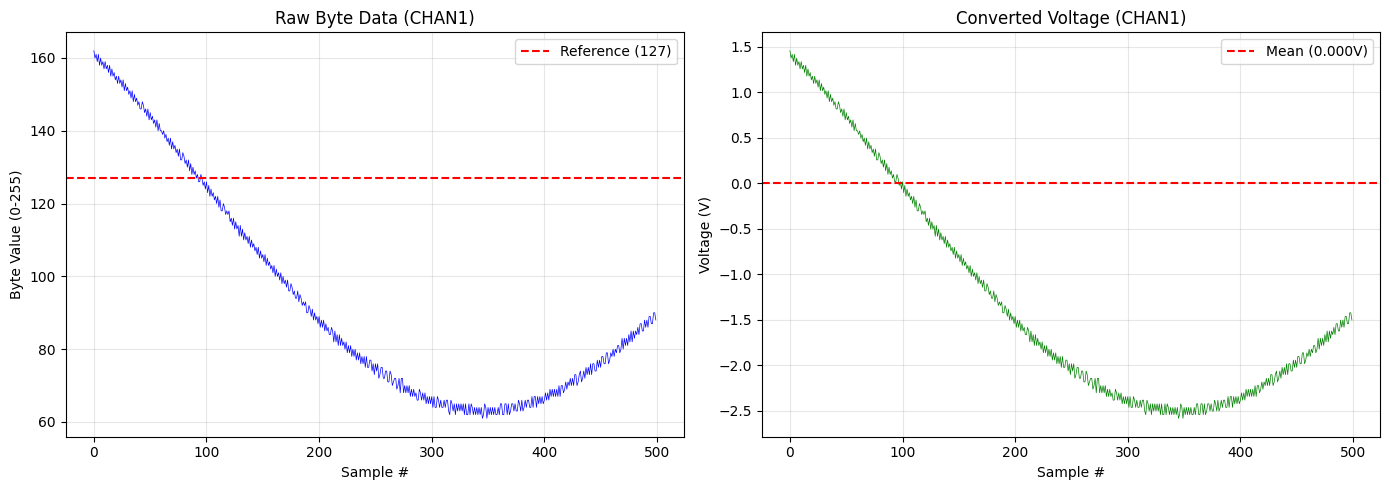

In [50]:
def diagnose_captured_waveform(osc, channel='CHAN1'):
    """Diagnose what's actually being captured"""
    print("=== Diagnosing Captured Waveform ===\n")
    
    # Configure and capture
    osc.write(f':WAV:SOUR {channel}')
    time.sleep(0.2)
    osc.write(':WAV:MODE NORM')
    time.sleep(0.2)
    osc.write(':WAV:FORM BYTE')
    time.sleep(0.2)
    
    preamble = osc.query(':WAV:PRE?')
    preamble_values = preamble.split(',')
    
    y_reference = int(preamble_values[9])
    y_increment = float(preamble_values[7])
    y_origin = float(preamble_values[8])
    
    print(f"Preamble values:")
    print(f"  y_reference: {y_reference}")
    print(f"  y_increment: {y_increment}")
    print(f"  y_origin: {y_origin}\n")
    
    # Capture data
    osc.write(':WAV:DATA?')
    time.sleep(0.5)
    
    original_timeout = osc.inst.timeout
    osc.inst.timeout = 30000
    
    try:
        header = osc.inst.read_raw(11)
        num_digits = int(header[1:2])
        data_length = int(header[2:2+num_digits].decode('utf-8'))
        raw_bytes = osc.inst.read_raw(data_length)
        
        # Convert to array
        byte_array = np.frombuffer(raw_bytes, dtype=np.uint8)
        
        print(f"Raw byte statistics:")
        print(f"  Min byte: {np.min(byte_array)}")
        print(f"  Max byte: {np.max(byte_array)}")
        print(f"  Mean byte: {np.mean(byte_array):.1f}")
        print(f"  Std dev: {np.std(byte_array):.1f}\n")
        
        # Convert to voltage
        y_data = (byte_array - np.mean(byte_array)) * y_increment
        
        print(f"Voltage statistics:")
        print(f"  Min voltage: {np.min(y_data):.6f} V")
        print(f"  Max voltage: {np.max(y_data):.6f} V")
        print(f"  Mean voltage: {np.mean(y_data):.6f} V")
        print(f"  Std dev: {np.std(y_data):.6f} V")
        print(f"  Vpp: {np.max(y_data) - np.min(y_data):.6f} V\n")
        
        # Plot first 200 samples to see pattern
        print("First 20 byte values:", byte_array[:20])
        print("First 20 voltage values:", y_data[:20])
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Raw bytes
        ax1.plot(byte_array[:500], 'b-', linewidth=0.5)
        ax1.axhline(y_reference, color='r', linestyle='--', label=f'Reference ({y_reference})')
        ax1.set_xlabel('Sample #')
        ax1.set_ylabel('Byte Value (0-255)')
        ax1.set_title(f'Raw Byte Data ({channel})')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Converted voltage
        ax2.plot(y_data[:500], 'g-', linewidth=0.5)
        ax2.axhline(np.mean(y_data), color='r', linestyle='--', label=f'Mean ({np.mean(y_data):.3f}V)')
        ax2.set_xlabel('Sample #')
        ax2.set_ylabel('Voltage (V)')
        ax2.set_title(f'Converted Voltage ({channel})')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
    finally:
        osc.inst.timeout = original_timeout


generator, osc = detect_rigol_instruments(verbose=1)
time.sleep(2)
diagnose_captured_waveform(osc, 'CHAN1')

time.sleep(1)
generator.close()
osc.close()


In [ ]:
def diagnose_waveform_format_fixed(channel='CHAN1'):
    """Diagnose the actual format and size being returned - FIXED"""
    
    generator, osc = detect_rigol_instruments(verbose=1)
    time.sleep(2)

    print("=== Diagnosing Waveform Format ===\n")
    
    osc.write(f':WAV:SOUR {channel}')
    time.sleep(0.2)
    osc.write(':WAV:MODE NORM')
    time.sleep(0.2)
    osc.write(':WAV:FORM BYTE')
    time.sleep(0.2)
    
    preamble = osc.query(':WAV:PRE?')
    preamble_values = preamble.split(',')
    format_type = int(preamble_values[0])
    points = int(preamble_values[2])
    
    print(f"Requested format: BYTE")
    print(f"Actual format returned: {['BYTE', 'WORD', 'ASCII'][format_type]}")
    print(f"Expected points: {points}\n")
    
    # STEP 1: Send the query command
    print("1. Sending :WAV:DATA? command...")
    osc.write(':WAV:DATA?')
    time.sleep(0.5)  # Give scope time to prepare data
    
    # STEP 2: Now read the response
    print("2. Attempting to read first 100 bytes...")
    osc.inst.timeout = 10000
    
    try:
        # Read the binary response header first
        # RIGOL format: #<digits><length><data>
        # e.g., #41200<1200 bytes of data>
        
        chunk = osc.inst.read_raw(100)
        print(f"✓ Got {len(chunk)} bytes")
        print(f"  Raw bytes: {chunk}")
        print(f"  As string: {chunk[:50]}")
        
        # Parse the header
        if chunk[0:1] == b'#':
            num_digits = int(chunk[1:2])
            data_length = int(chunk[2:2+num_digits])
            print(f"\n  Header parsed:")
            print(f"    Format: # (IEEE block)")
            print(f"    Num digits: {num_digits}")
            print(f"    Data length: {data_length} bytes")

        time.sleep(2)
        generator.close()
        osc.close()
        
        return True
        
    except Exception as e:
        print(f"✗ Failed: {e}")
        import traceback
        traceback.print_exc()
        return False


# Run diagnostic
diagnose_waveform_format_fixed('CHAN1')


Detecting...
Generator Detected.
Oscilloscope Detected.
=== Diagnosing Waveform Format ===

Requested format: BYTE
Actual format returned: BYTE
Expected points: 1200

1. Sending :WAV:DATA? command...
2. Attempting to read first 100 bytes...
✓ Got 100 bytes
  Raw bytes: b'#9000001200\xa2\xa0\xa1\x9f\xa1\x9e\xa0\x9e\x9f\x9d\x9f\x9c\x9e\x9c\x9d\x9b\x9b\x9d\x9c\x9a\x9b\x99\x9b\x98\x9a\x98\x99\x97\x99\x96\x98\x96\x97\x95\x96\x94\x94\x96\x95\x93\x94\x92\x92\x94\x93\x91\x92\x90\x92\x90\x8f\x91\x90\x8e\x8f\x8d\x8d\x8f\x8e\x8c\x8d\x8b\x8c\x8a\x8b\x89\x8a\x88\x89\x88\x89\x86\x88\x86\x87\x85\x86\x84\x86\x84\x85\x83\x84\x82\x83\x81\x81\x83\x82'
  As string: b'#9000001200\xa2\xa0\xa1\x9f\xa1\x9e\xa0\x9e\x9f\x9d\x9f\x9c\x9e\x9c\x9d\x9b\x9b\x9d\x9c\x9a\x9b\x99\x9b\x98\x9a\x98\x99\x97\x99\x96\x98\x96\x97\x95\x96\x94\x94\x96\x95'

  Header parsed:
    Format: # (IEEE block)
    Num digits: 9
    Data length: 1200 bytes


### 5 - Automated Code


 Create a generic code that generates a sinus with the DG1022 and measure it with the DS1104.
 - The measured value must be plotted with Matplotlib, in an understandable voltage and time scale.
 - The legend of the plot should have the frequency, VPP, Vmin and Vmax. 
 - At the same time, the values generated and measured have to be stored in a TXT or CSV file for later use.

In [53]:


def plot_single_waveforms(time_ms, voltage_array, frequency, amplitude, vpp_measured, vmax, vmin, vrms):
    """Plot single waveform with all parameters in legend."""
    # CREATE figure and axis (was undefined before)
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(time_ms, voltage_array, linewidth=1.5, color='blue')
    ax.axhline(vmax, color='red', linestyle='--', linewidth=1, alpha=0.7, label=f'Vmax: {vmax:.3f} V')
    ax.axhline(vmin, color='green', linestyle='--', linewidth=1, alpha=0.7, label=f'Vmin: {vmin:.3f} V')
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Voltage (V)', fontsize=12)
    ax.set_title(f'Sine Wave Measurement\nFrequency: {frequency/1000:.1f} kHz | VPP: {vpp_measured:.3f} V', 
                    fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Create legend with all key parameters
    legend_text = f"Frequency: {frequency/1000:.1f} kHz\nVPP (set): {amplitude:.3f} V\nVPP (meas): {vpp_measured:.3f} V\nVmax: {vmax:.3f} V\nVmin: {vmin:.3f} V\nVRMS: {vrms:.3f} V"
    ax.text(0.98, 0.97, legend_text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()



def auto(gen, osc, channel, output_file, frequency=1000, amplitude=2):
    # 1. Generate sine wave
    print("Generating sine wave...")
    gen.generate_waveform(
            channel=channel,
            waveform_type=wave["sin"],
            frequency=frequency,
            amplitude=amplitude,
            offset=0
    )
    time.sleep(2)  # Let signal stabilize

    # 2. Capture waveform
    print("Capturing waveform...")
    osc.write(f':{channel}:DISP ON')
    time.sleep(0.5)
    time_array, voltage_array, preamble = capture_waveform(osc, channel)


    # 3. Params
    vpp_measured = np.max(voltage_array) - np.min(voltage_array)
    vmax = np.max(voltage_array)
    vmin = np.min(voltage_array)
    vrms = np.sqrt(np.mean(voltage_array**2))


    # Convert time to ms for readability
    time_ms = time_array * 1e3

    # 4. Plot waveform
    plot_single_waveforms(time_ms, voltage_array, frequency, amplitude, vpp_measured, vmax, vmin, vrms)

    # 5. Save to CSV
    saveToCSV(output_file, time_array, voltage_array, frequency, amplitude, vpp_measured, vmax, vmin, vrms)





def saveToCSV(output_file, time_array, voltage_array, frequency, amplitude, vpp_measured, vmax, vmin, vrms):
    """Save waveform data to CSV file with metadata header."""
    import csv
    from datetime import datetime
    
    # Generate timestamp
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Open file ONCE and write everything before closing
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        
        # Write metadata header
        writer.writerow(['# Automated Sine Wave Measurement'])
        writer.writerow(['# Timestamp', timestamp])
        writer.writerow(['# Frequency (Hz)', frequency])
        writer.writerow(['# Amplitude Set (Vpp)', amplitude])
        writer.writerow(['# VPP Measured (V)', f"{vpp_measured:.6f}"])
        writer.writerow(['# Vmax (V)', f"{vmax:.6f}"])
        writer.writerow(['# Vmin (V)', f"{vmin:.6f}"])
        writer.writerow(['# VRMS (V)', f"{vrms:.6f}"])
        writer.writerow([])  # Blank line separator
        writer.writerow(['Time (s)', 'Voltage (V)'])
        
        # Write all data rows (INSIDE the with block)
        for t, v in zip(time_array, voltage_array):
            writer.writerow([f"{t:.9f}", f"{v:.6f}"])
    
    print(f"✓ Data saved to {output_file}")




Detecting...
Oscilloscope Detected.
Generator Detected.
Generating sine wave...
Capturing waveform...
  Capturing 1200 samples from CH1...
  Header: b'#9000001200', data_length=1200
  ✓ Captured 1200 points successfully


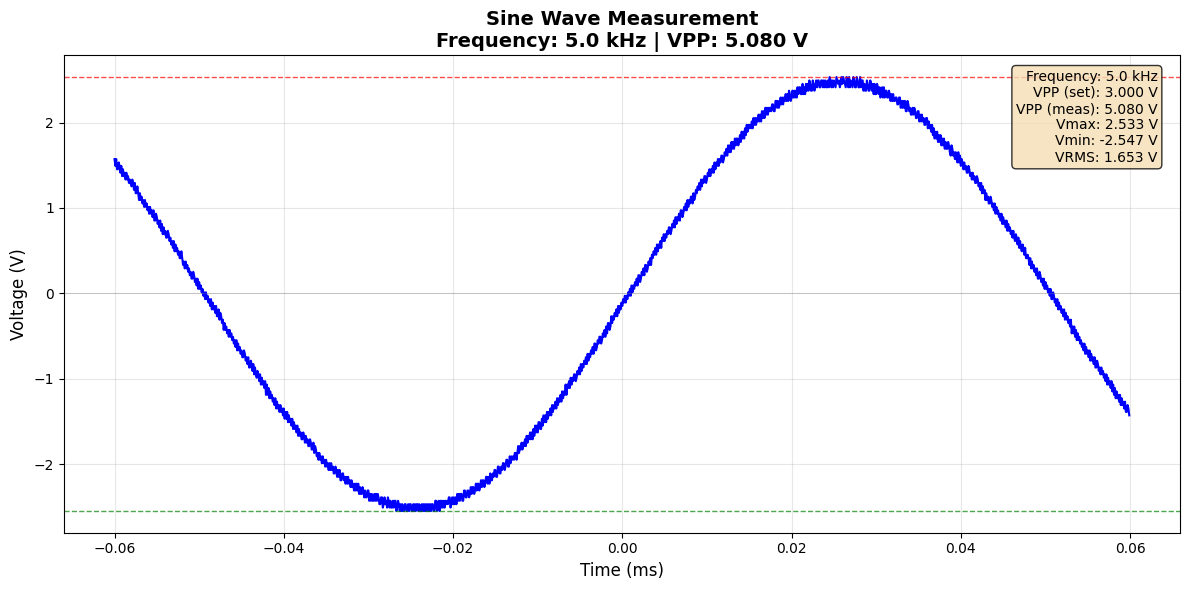

✓ Data saved to saves/sine_measurement.csv


In [54]:
# Connect instruments
generator, osc = detect_rigol_instruments()
time.sleep(2)

if generator and osc:

    # Test parameters
    test_frequency = 5000   # 5 kHz
    test_amplitude = 3.0    # 3 Vpp
    
    # Run automated measurement
    results = auto(
        gen=generator,
        osc=osc,
        channel='CH1',
        output_file='saves/sine_measurement.csv',
        frequency=test_frequency,
        amplitude=test_amplitude
    )


    # Close connections
    generator.close()
    osc.close()







---
## Session 3 : Arduino and Power Supply

### Arduino Class

Note : 
- pip uninstall serial pyutils -y
- pip uninstall pyserial
- pip install pyserial



Find the port your Arduino is connected to : 
> ls -l /dev/ttyACM* /dev/ttyUSB* 2>/dev/null

mine is : 
> crw-rw-rw-. 1 root dialout 166, 1 Dec 11 16:04  /dev/ttyACM1


In [8]:
# Importing Libraries
import time
import serial

class ArduinoInterface:
    def __init__(self, port="/dev/ttyACM1", baud=115200):
        self.ser = serial.Serial(port, baud, timeout=1)
        time.sleep(2)  # L’Arduino reboot au moment de l'ouverture du port

    def send_cmd(self, cmd):
        """
        Docstring for send_cmd
        
        :param self: Description
        :param cmd: Description
        """
        self.ser.write((cmd + "\n").encode())
        return self.ser.readline().decode().strip()

    def analog_read(self, pin):
        """
        Docstring for analog_read
        
        :param self: Description
        :param pin: Description
        """
        resp = self.send_cmd(f"ANALOG_READ A{pin}?")
        _, val = resp.split(":")
        return int(val)

    def digital_read(self, pin):
        """
        Docstring for digital_read
        
        :param self: Description
        :param pin: Description
        """
        resp = self.send_cmd(f"DIGITAL_READ D{pin}?")
        _, val = resp.split(":")
        return int(val)

    def pwm_write(self, pin, value):
        """
        Docstring for pwm_write
        
        :param self: Description
        :param pin: Description
        :param value: Description
        """
        resp = self.send_cmd(f"PWM D{pin} {value}")
        return resp  # "OK" normalement

    def analog_write(self, pin, value):
        return self.send_cmd(f"ANALOG_WRITE D{pin} {value}")

    def digital_write(self, pin, value):
        return self.send_cmd(f"DIGITAL_WRITE D{pin} {value}")

    def led_on(self):
        return self.send_cmd("LED ON")

    def led_off(self):
        return self.send_cmd("LED OFF")

    def blink(self, delay_ms):
        return self.send_cmd(f"BLINK {delay_ms}")


arduino = ArduinoInterface()

print(arduino.analog_read(0))
print("Digital D7:", arduino.digital_read(7))
print("PWM write:", arduino.pwm_write(5, 120))

print(arduino.analog_write(5, 128))
print("Digital HIGH:", arduino.digital_write(7, 0))
print("LED ON:", arduino.led_on())
print("LED OFF:", arduino.led_off())
print("Blink:", arduino.blink(300))


# Code de l'arduino sur /home/valatras/Arduino/labo3_exercice1_hardware_testing

410
Digital D7: 1
PWM write: OK
La pin 5a comme valeur : 128
Digital HIGH: Boop
LED ON: 
LED OFF: 
Blink: OK


### 1-Arduino:

### 2-All together:

Gather all your knowledge to validate some information from the datasheet of the LM741 :

- Supply the circuit with the right potential, try some different values within the possible
range.
- Generate a sinus and a triangle signal as input with the help of the wave generator.
- Measure with the oscilloscope the input and output.
- Define a protocol of measure in order to make it repeatable.

https://www.ti.com/lit/ds/symlink/lm741.pdf

#### Expected :

- GBW=1.5MHz
- Gain=2
- Vsupply = +-12V

=> Datasheet estimates GBW :
- min : 0.437
- Typ : 1.5 
- Max : /

=> Vin,max = Vsat/G = 10.5/2 = 5.25 V max at Vin.




Output clips when Vsupply < +-5v




LM741 FREQUENCY RESPONSE ANALYSIS (Bode Magnitude Diagram)
Configuration:
  R1 (feedback) = 10.0 kΩ
  R2 (ground)   = 10.0 kΩ
  DC Gain       = 2.000 (6.02 dB)
  Input Signal  = 0.500 Vpp
  GBW           = 1.50 MHz
  Theoretical -3dB Frequency = 750.0 kHz
──────────────────────────────────────────────────────────────────────
Testing 10 frequency points from 1.0 kHz to 2.00 MHz

[1/10] Testing 1.0 kHz... ✓ Gain: 1.977 (5.92 dB)
[2/10] Testing 10.0 kHz... ✓ Gain: 1.954 (5.82 dB)
[3/10] Testing 50.0 kHz... ✓ Gain: 1.923 (5.68 dB)
[4/10] Testing 100.0 kHz... ✓ Gain: 1.923 (5.68 dB)
[5/10] Testing 300.0 kHz... ✓ Gain: 1.369 (2.73 dB)
[6/10] Testing 500.0 kHz... ✓ Gain: 0.844 (-1.48 dB)
[7/10] Testing 750.0 kHz... ✓ Gain: 0.578 (-4.76 dB)
[8/10] Testing 1000.0 kHz... ✓ Gain: 0.438 (-7.18 dB)
[9/10] Testing 1500.0 kHz... ✓ Gain: 0.292 (-10.68 dB)
[10/10] Testing 2000.0 kHz... ✓ Gain: 0.231 (-12.74 dB)
Interpolating -3dB point between 100000.0 Hz (5.679933127304016 dB) and 300000.0 Hz (2.7295

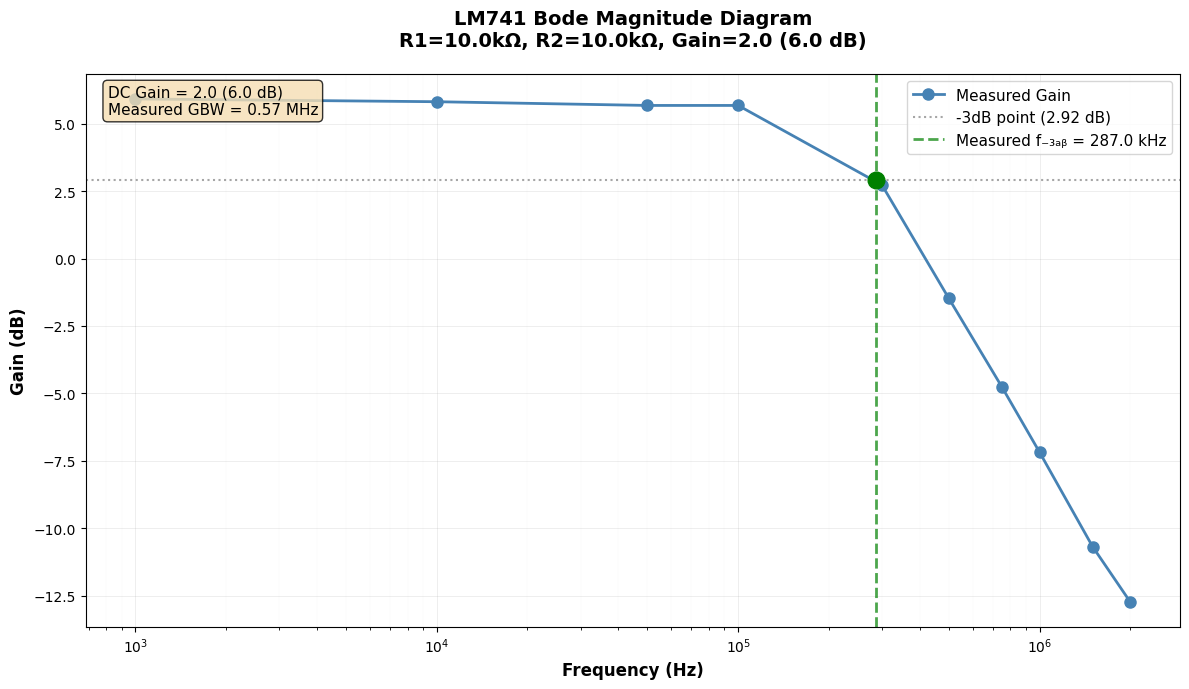

In [ ]:
import numpy as np

# 1. Empirically get the dB_Gain at 100Hz , substract 3dB from it (target_dB) and sweep to find the frequency where you get this target_dB
    # ex. 
        # G_init = 2 = 20*log2(2) = 6.02 dB
        # fc : G(-3dB) = G_init -3 = 3.02 dB, now find fc such that we have a gain of 3.02 dB

# === Test 1 : Measure the Gain =========

def check_gain(R1, R2, V_in_pp, freq=1000, verbose=False, plot=False):
    """
    Measure LM741 op-amp gain with non-inverting configuration.
    R1 = feedback resistor (from output to IN-)
    R2 = resistor from IN- to GND
    Expected gain = 1 + R1/R2
    """
    gain_expected = 1 + (R1 / R2)
    V_out_expected = V_in_pp * gain_expected
    
    if verbose:
        print(f"\n=== LM741 Gain Test ===")
        print(f"R1={R1}Ω, R2={R2}Ω → Expected gain: {gain_expected:.3f}")
        print(f"Input: {V_in_pp:.2f} Vpp @ {freq} Hz")
        print(f"Expected output (low frequency): {V_out_expected:.2f} Vpp")
        
    # Connect instruments
    generator, oscilloscope = detect_rigol_instruments(verbose=0)
    if not (oscilloscope and generator):
        print("Error: Instruments not detected!")
        return
    
    try:
        # Generate sine wave on CH1 (input to LM741)
        generator.generate_waveform(
            channel="CH1", 
            waveform_type="sin", 
            frequency=freq, 
            amplitude=V_in_pp,
            offset=0  # Centered at 0V for dual supply
        )
        time.sleep(2)  # Stabilize
        
        # Enable both channels on scope
        oscilloscope.write(':CHAN1:DISP ON')
        oscilloscope.write(':CHAN2:DISP ON')
        time.sleep(0.5)
        
        # Capture input (CH1) and output (CH2)
        if verbose: print("\nCapturing waveforms...")

        t_in, v_in, _ = capture_waveform(oscilloscope, 'CHAN1', verbose=False)
        t_out, v_out, _ = capture_waveform(oscilloscope, 'CHAN2', verbose=False)
        
        # Calculate measurements
        V_in_measured = np.max(v_in) - np.min(v_in)
        V_out_measured = np.max(v_out) - np.min(v_out)
        gain_measured = V_out_measured / V_in_measured if V_in_measured > 0 else 0
        gain_db = 20 * np.log10(gain_measured) if gain_measured > 0 else -np.inf
        # error_pct = abs(gain_measured - gain_expected) / gain_expected * 100

        # Results
        if verbose:
            print(f"\n=== Results ===")
            print(f"  Input  Vpp:  {V_in_measured:.4f} V")
            print(f"  Output Vpp:  {V_out_measured:.4f} V")
            print(f"  Gain (V/V):  {gain_measured:.4f}")
            print(f"  Gain (dB):   {gain_db:.2f} dB")
            
        # Quick plot
        if plot :
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))
            # Input signal
            ax1.plot(t_in * 1e3, v_in, linewidth=1.5, color='steelblue', label=f'Input: {V_in_measured:.3f} Vpp')
            ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax1.set_ylabel('Voltage (V)', fontsize=11)
            ax1.set_title(f'LM741 Gain Measurement: R1={R1/1e3:.1f}kΩ, R2={R2/1e3:.1f}kΩ @ {freq/1e3:.1f} kHz', 
                fontsize=12, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            ax1.legend(fontsize=10)
            
            # Output signal
            ax2.plot(t_out * 1e3, v_out, linewidth=1.5, color='darkorange', 
                    label=f'Output: {V_out_measured:.3f} Vpp | Gain: {gain_measured:.3f} ({gain_db:.2f} dB)')
            ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax2.set_xlabel('Time (ms)', fontsize=11)
            ax2.set_ylabel('Voltage (V)', fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=10)
            
            plt.tight_layout()
            plt.show()
        
        return {
            'frequency': freq,
            'gain_expected': gain_expected,
            'gain_measured': gain_measured,
            'gain_db': gain_db,
            'v_in': V_in_measured,
            'v_out': V_out_measured
        }
        
    finally:
        generator.close()
        oscilloscope.close()


# === Test 2: Find the cutoff frequency at a given gain =========

def bode_diagram(R1, R2, V_in_pp, frequencies, GBW=1.5e6, plot=True):
    gain_expected = 1 + (R1 / R2)
    f_3db_theoretical = GBW / gain_expected
    
    print(f"\n{'='*70}")
    print(f"LM741 FREQUENCY RESPONSE ANALYSIS (Bode Magnitude Diagram)")
    print(f"{'='*70}")
    print(f"Configuration:")
    print(f"  R1 (feedback) = {R1/1e3:.1f} kΩ")
    print(f"  R2 (ground)   = {R2/1e3:.1f} kΩ")
    print(f"  DC Gain       = {gain_expected:.3f} ({20*np.log10(gain_expected):.2f} dB)")
    print(f"  Input Signal  = {V_in_pp:.3f} Vpp")
    print(f"  GBW           = {GBW/1e6:.2f} MHz")
    print(f"  Theoretical -3dB Frequency = {f_3db_theoretical/1e3:.1f} kHz")
    print(f"{'─'*70}")
    print(f"Testing {len(frequencies)} frequency points from {frequencies[0]/1e3:.1f} kHz to {frequencies[-1]/1e6:.2f} MHz")
    print(f"{'='*70}\n")
    
    results = []
    for i, freq in enumerate(frequencies, 1):
        print(f"[{i}/{len(frequencies)}] Testing {freq/1e3:.1f} kHz...", end=' ')
        result = check_gain(R1=R1, R2=R2, V_in_pp=V_in_pp, freq=freq, verbose=False, plot=False)
        if result:
            results.append(result)
            print(f"✓ Gain: {result['gain_measured']:.3f} ({result['gain_db']:.2f} dB)")
        else:
            print(f"✗ Failed")
        time.sleep(1)
    
    # Extract data for plotting
    freqs_measured = [r['frequency'] for r in results]
    gains_linear = [r['gain_measured'] for r in results]
    gains_db = [r['gain_db'] for r in results]
    
    # Set DC gain reference at 1000 Hz
    dc_gain_db = gains_db[0] if gains_db else 0
    # Find -3dB point (where gain drops by 3dB from DC gain) 
    target_db = dc_gain_db - 3

    f_3db_measured = None
    for i, gain_db in enumerate(gains_db):
        # check when we have a greater attenuation than 3dB
        if gain_db <= target_db:
            # Linear interpolation (need at least 2 measurements points)
            if i > 0:
                print(f"Interpolating -3dB point between {freqs_measured[i-1]} Hz ({gains_db[i-1]} dB) and {freqs_measured[i]} Hz ({gains_db[i]} dB)")
                f1, f2 = freqs_measured[i-1], freqs_measured[i]
                g1, g2 = gains_db[i-1], gains_db[i]
                f_3db_measured = f1 + (target_db - g1) * (f2 - f1) / (g2 - g1)
            else:
                f_3db_measured = freqs_measured[i]
            break
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"📊 FREQUENCY RESPONSE SUMMARY")
    print(f"{'='*70}")
    print(f"DC Gain (100 Hz):        {gains_linear[0]:.3f} V/V ({gains_db[0]:.2f} dB)")
    if f_3db_measured:
        print(f"Measured -3dB Cutoff:    {f_3db_measured/1e3:.1f} kHz")
        # print(f"Theoretical -3dB Cutoff: {f_3db_theoretical/1e3:.1f} kHz")
        # error_f3db = abs(f_3db_measured - f_3db_theoretical) / f_3db_theoretical * 100
        # print(f"Error:                   {error_f3db:.1f}%")
    else:
        print(f"Measured -3dB Cutoff:    Not reached in test range")
    print(f"Gain @ 1 MHz:            {gains_linear[-1]:.3f} V/V ({gains_db[-1]:.2f} dB)")
    print(f"{'='*70}\n")
    

    if plot:
        # Plot Bode diagram
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Plot measured data
        ax.semilogx(freqs_measured, gains_db, 'o-', linewidth=2, markersize=8, 
                    color='steelblue', label='Measured Gain', zorder=3)
        
        # Plot -3dB line (horizontal reference)
        ax.axhline(dc_gain_db - 3, color='gray', linestyle=':', linewidth=1.5, 
                    alpha=0.7, label=f'-3dB point ({dc_gain_db-3:.2f} dB)')
    
        # Plot measured -3dB frequency (vertical line + marker)
        if f_3db_measured:
            ax.axvline(f_3db_measured, color='green', linestyle='--', linewidth=2, 
                    alpha=0.7, label=f'Measured f₋₃ₐᵦ = {f_3db_measured/1e3:.1f} kHz')
            ax.plot(f_3db_measured, target_db, 'go', markersize=12, zorder=4)
            
            # Calculate measured GBW
            measured_gbw = f_3db_measured * gain_expected
            gbw_text = f'Measured GBW = {measured_gbw/1e6:.2f} MHz'
        else:
            gbw_text = 'GBW: Not determined (f₋₃ₐᵦ not reached)'
        
        # Labels and formatting
        ax.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Gain (dB)', fontsize=12, fontweight='bold')
        ax.set_title(f'LM741 Bode Magnitude Diagram\nR1={R1/1e3:.1f}kΩ, R2={R2/1e3:.1f}kΩ, Gain={gain_expected:.1f} ({20*np.log10(gain_expected):.1f} dB)', 
                    fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, which='both', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.grid(True, which='minor', alpha=0.1, linestyle='-', linewidth=0.3)
        ax.legend(fontsize=11, loc='upper right')
        
        # Add text annotation with key parameters
        textstr = f'DC Gain = {gain_expected:.1f} ({20*np.log10(gain_expected):.1f} dB)\n{gbw_text}'
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    return {
        'frequencies': freqs_measured,
        'gains_linear': gains_linear,
        'gains_db': gains_db,
        'f_3db_theoretical': f_3db_theoretical,
        'f_3db_measured': f_3db_measured,
        'results': results
    }


#  ===================================
# Convention : CH1 for input, CH2 for output
bandWidth = 1.5e6  # 1.5 MHz for LM741

# GAIN = 1+10/10 = 2
r1 = 10000  # 10kΩ
r2 = 10000   # 10kΩ


freqs = [1e3, 10e3, 50e3, 100e3, 300e3, 500e3, 750e3, 1e6, 1.5e6, 2e6]

bode_data = bode_diagram(
    R1=r1, 
    R2=r2, 
    V_in_pp=0.5, 
    frequencies=freqs, 
    GBW=1.5e6
)




# Other (similar) method to find f₋₃dB :
    # G_init = 2 = 6.02 dB
    # G(-3dB) = 3.02 dB
    # reconvertir en lineaire : 10^(3.02/20) = 1.4125 at fc
    # so if Vin = 0.5, then Vout = Vin * 1.4125 = 0.70625 Vpp at fc

    # OR
    # G_fc = G_init / sqrt(2) = 2 / 1.414 = 1.414
    # Find the frequency where the output amplitude drops to the calculated V_(-3dB) value. This frequency is your f₋₃dB.





=== LM741 Gain Test ===
R1=10000Ω, R2=10000Ω → Expected gain: 2.000
Input: 0.50 Vpp @ 1000 Hz
Expected output: 1.00 Vpp

Capturing waveforms...
  Capturing 1200 samples from CHAN1...
  Header: b'#9000001200', data_length=1200
  ✓ Captured 1200 points successfully
  Capturing 1200 samples from CHAN2...
  Header: b'#9000001200', data_length=1200
  ✓ Captured 1200 points successfully

=== Results ===
  Input  Vpp:  0.0240 V
  Output Vpp:  0.0400 V
  Gain (V/V):  1.6667 (expected 2.000)
  Gain (dB):   4.44 dB
  Error:       16.67%

LM741 FREQUENCY RESPONSE ANALYSIS (Bode Magnitude Diagram)
Configuration:
  R1 (feedback) = 10.0 kΩ
  R2 (ground)   = 10.0 kΩ
  DC Gain       = 2.000 (6.02 dB)
  Input Signal  = 0.500 Vpp
  GBW           = 1.50 MHz
  Theoretical -3dB Frequency = 750.0 kHz
──────────────────────────────────────────────────────────────────────
Testing 9 frequency points from 0.1 kHz to 1.00 MHz

[1/9] Testing 0.1 kHz... ✓ Gain: 1.200 (1.58 dB)
[2/9] Testing 1.0 kHz... ✓ Gain: 1.4

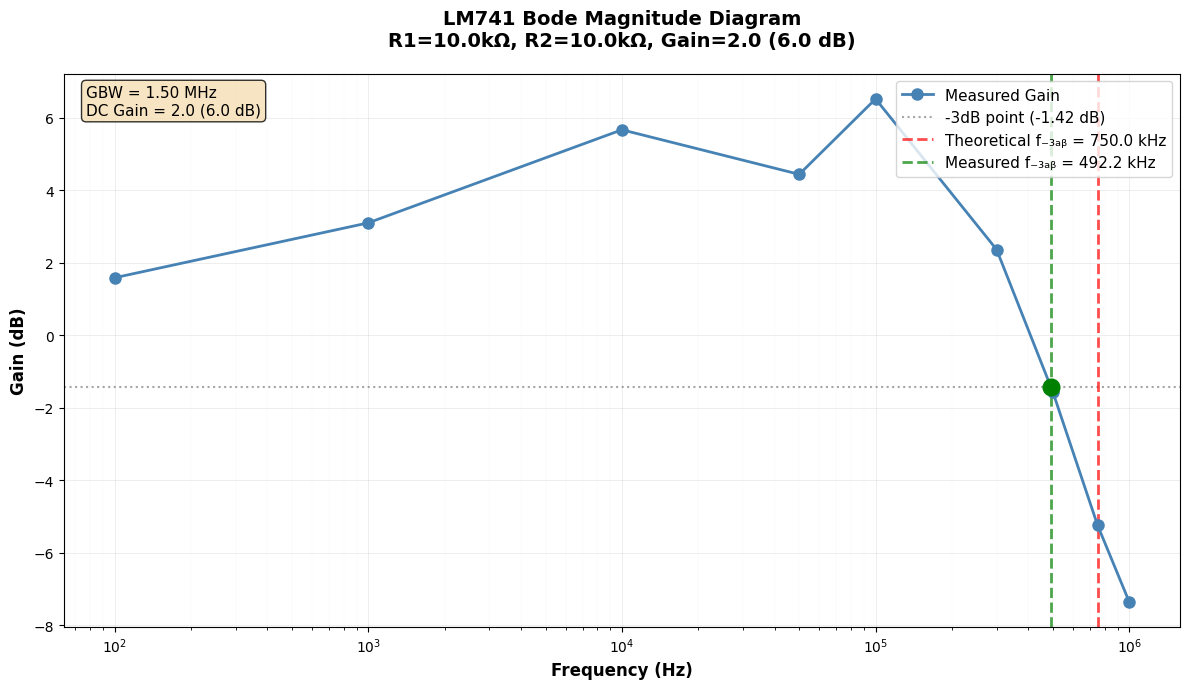

In [ ]:

# High Gain = 1 + 10/1 = 11
r1 = 1000  # 1kΩ
r2 = 10000   # 10kΩ


# Check gain
check_gain(R1 = r1, R2 = r2, V_in_pp = 0.5, freq=1000, verbose=True, plot=False)  # Gain = 2

freqs = [100, 1e3, 10e3, 50e3, 100e3, 300e3, 500e3, 750e3, 1e6]

bode_data = bode_diagram(
    R1=r1, 
    R2=r2, 
    V_in_pp=0.5, 
    frequencies=freqs, 
    GBW=1.5e6
)



In [ ]:
# LOW GAIN = 1 + 1000/1000 = 1.1
r1 = 10000  # 10kΩ
r2 = 100   # 100Ω


# Check gain
check_gain(R1 = r1, R2 = r2, V_in_pp = 0.5, freq=1000, verbose=True, plot=False)  # Gain = 2

freqs = [100, 1e3, 10e3, 50e3, 100e3, 300e3, 500e3, 750e3, 1e6]

bode_data = bode_diagram(
    R1=r1, 
    R2=r2, 
    V_in_pp=0.5, 
    frequencies=freqs, 
    GBW=1.5e6
)



### Single tests

In [36]:
# Add this diagnostic function to your code:

def diagnose_circuit_health(R1, R2, V_in_pp, freq):
    """Check if circuit is working as expected at DC"""
    print("\n" + "="*70)
    print("CIRCUIT HEALTH DIAGNOSTIC")
    print("="*70)
    
    # Test at very low frequency (100 Hz)
    result_dc = check_gain(R1=R1, R2=R2, V_in_pp=V_in_pp, freq=freq, verbose=True, plot=False)
    
    if result_dc:
        gain_error = abs(result_dc['gain_measured'] - result_dc['gain_expected'])
        
        print(f"\n🔍 Analysis:")
        print(f"  Expected gain: {result_dc['gain_expected']:.3f}")
        print(f"  Measured gain: {result_dc['gain_measured']:.3f}")
        print(f"  Gain error: {gain_error:.3f} ({result_dc['error_pct']:.1f}%)")
        
        if result_dc['error_pct'] > 10:
            print(f"\n⚠️  WARNING: DC gain error >10%")
            print(f"  Possible causes:")
            print(f"    - Resistor tolerance (measure actual values with DMM)")
            print(f"    - Poor connections on breadboard")
            print(f"    - Op-amp not properly powered")
            
        if result_dc['error_pct'] < 5:
            print(f"\n✓ DC gain is good (<5% error)")
            print(f"\n  If frequency response is still wrong, check:")
            print(f"    1. Oscilloscope probe setting (use 10x, not 1x)")
            print(f"    2. Probe compensation (square wave test)")
            print(f"    3. Minimize wire lengths")
            print(f"    4. Use ground spring on probe tip")
            print(f"    5. Check for parasitic capacitance")
    
    return result_dc

# Run diagnostic
r1 = 10000  # 10kΩ
r2 = 10000   # 10kΩ
freq = 30000  # 30 kHz
diagnose_circuit_health(R1=r1, R2=r2, V_in_pp=0.5, freq=freq)


CIRCUIT HEALTH DIAGNOSTIC

=== LM741 Gain Test ===
R1=10000Ω, R2=10000Ω → Expected gain: 2.000
Input: 0.50 Vpp @ 30000 Hz
Expected output: 1.00 Vpp

Capturing waveforms...
  Capturing 1200 samples from CHAN1...
  Header: b'#9000001200', data_length=1200
  ✓ Captured 1200 points successfully
  Capturing 1200 samples from CHAN2...
  Header: b'#9000001200', data_length=1200
  ✓ Captured 1200 points successfully

=== Results ===
  Input  Vpp:  5.1200 V
  Output Vpp:  8.6400 V
  Gain (V/V):  1.6875 (expected 2.000)
  Gain (dB):   4.54 dB
  Error:       15.62%

🔍 Analysis:
  Expected gain: 2.000
  Measured gain: 1.688
  Gain error: 0.312 (15.6%)

⚠️  WARNING: DC gain error >10%
  Possible causes:
    - Resistor tolerance (measure actual values with DMM)
    - Poor connections on breadboard
    - Op-amp not properly powered


{'frequency': 30000,
 'gain_expected': 2.0,
 'gain_measured': np.float64(1.6875),
 'gain_db': np.float64(4.5448756300612505),
 'v_in': np.float64(5.12),
 'v_out': np.float64(8.64),
 'error_pct': np.float64(15.625)}

### Step-by-step:

In [ ]:
r1 = 10000
r2 = 10000
freq = 1000

check_gain(R1 = r1, R2 = r2, V_in_pp = 0.5, freq=freq, verbose=True, plot=False)  # Gain = 2

### 3-All together Bis:

Gather all your knowledge to reproduce the I-V curve of the N-mos transistor BS170. Its datasheet
is available here :

- Polarize the circuit with the right potential, try some different values within the possible
range.
- Generate a sinus and a triangle signal as input with the help of the wave generator.
- Measure with the oscilloscope the input and output.
- Define a protocol of measure in order to make it repeatable.
- Trace the graphic of the I-V curve and save the image

https://docs.rs-online.com/7137/0900766b81538660.pdf

In [ ]:
#




### x-Challenge:

### x-ChallengeBis: PowerSupply

---

# Setup & Debug

### Windows:

1. Create a new -venv :

```>>> python -m venv HTP_venv ```

requirements.txt :
```
numpy
matplotlib

ipykernel
jupyter
```


2. Activate the venv and install dependencies :
```
>>> .\HTP_venv\Scripts\Activate.ps1
>>> pip install -r requirements.txt
```

3. Register our venv as a Jupyter kernel:
```
>>> python -m ipykernel install --user --name=HTP_venv --display-name="Python (HTP_venv)"
>>> jupyter kernelspec list
```
(should show) : htp_venv         C:\Users\user\AppData\Roaming\jupyter\kernels\htp_venv


#### Drivers (Windows 10):

DG1022 : 
- Goto https://www.rigolna.com/download/ 
- Filter by DG1000 in the search bar.
- then Download > UltraSigma Instrument Connectivity Driver


#### Debug:

If Rigol devices are not detected, use : 
- Device Manager (Windows)

### Linux (Fedora):

1. Create a new -venv :

```>>> python -m venv HTP_venv ```

requirements.txt :
```
numpy
matplotlib

ipykernel
jupyter
```


2. Activate the venv and install dependencies :
```
>>> source HTP_venv/bin/activate
>>> pip install -r requirements.txt
```

3. Register our venv as a Jupyter kernel:
```
>>> python -m ipykernel install --user --name=HTP_venv --display-name="Python (HTP_venv)"
>>> jupyter kernelspec list
```
(should show) : htp_venv         C:\Users\user\AppData\Roaming\jupyter\kernels\htp_venv


#### Debug:

First check to see if pyvisa is well installed and can at least read ASRL (fictive serial ports).

Then we'll try making it read physical USB ports.

In [ ]:
import pyvisa
rm = pyvisa.ResourceManager('@py')
print(rm.list_resources())
print(rm)

If Rigol devices are not detected (linux), use : 
> lsusb

This should show :
```
Bus 001 Device 120: ID 1ab1:0588 Rigol Technologies DS1000 SERIES
Bus 001 Device 121: ID 1ab1:04ce Rigol Technologies DS1xx4Z/MSO1xxZ series
```

.

Create `udev` rules in the following file : 
>sudo nano /etc/udev/rules.d/99-usbtmc-rigol.rules

Write : 
SUBSYSTEM=="usb", ATTR{idVendor}=="1ab1", ATTR{idProduct}=="0588", MODE="0666"
SUBSYSTEM=="usb", ATTR{idVendor}=="1ab1", ATTR{idProduct}=="04ce", MODE="0666"
SUBSYSTEM=="usb", ATTR{idVendor}=="0400", ATTR{idProduct}=="09c4", MODE="0666"


.

Verify:
>vass@NightBlue:~$ cat /etc/udev/rules.d/99-usbtmc-rigol.rules

SUBSYSTEM=="usb", ATTR{idVendor}=="1ab1", ATTR{idProduct}=="0588", MODE="0666"

SUBSYSTEM=="usb", ATTR{idVendor}=="1ab1", ATTR{idProduct}=="04ce", MODE="0666"

SUBSYSTEM=="usb", ATTR{idVendor}=="0400", ATTR{idProduct}=="09c4", MODE="0666"


.

Recharge :
> sudo udevadm control --reload-rules

> sudo udevadm trigger

Check if usbtmc is loaded :
> lsmod | grep usbtmc
